## Introduction

## Who am I?

## Where do I work?

## What do I do?

## Bulk sequencing data

- 1953 - DNA structure
- 1953 - First protein amino acid sequencing
- 1975 - Sanger sequencing
- 1985 - First PCR
- 1988 - PCR with Taq polymerase
- 1988 - Automation of Sanger sequencing
- 1993 - First qPCRs
- 1996 - Pyrosequencing
- 1995 - Microarrays
    - Quantify gene expression using a chip
- 2001 - First draft of the human genome
- 2003 - First NGS DNA sequencer
- 2005 - Next-generation sequencing
- 2009 - First single-cell RNA-seq [@tang2009mrna]
- 2010 - RNA-seq
- 2013 - Single-cell RNA-seq is declared method of the year

[@zhu2020pcr; @gondane2023revealing]

## Bulk RNA-seq

- RNA-seq is a method to quantify gene expression in a sample by sequencing the RNA molecules in the sample.
- Can be used to quantify gene expression, identify alternative splicing, identify novel genes, quantify allele-specific expression, etc.
- Can estimate the **average expression** level for each gene across a population of cells.

## Single-cell RNA-seq

- scRNA-seq methods can quantify gene expression in individual cells.
- Can be used to study cell  heterogeneity, sunch as identify cell types, cell states, heterogeneity, and cell-cell interactions.
- Suffers from drop-out, higher technical noise and lower genomic resolution compared to bulk RNA-seq.

## Sample representation

- In bulk data, each sample is repressented by a vector, where each value is a gene.
- In single cell data, each sample is a matrix, where each row is a gene and each column is a cell.

\begin{align}
Bulk &= \begin{bmatrix} gene_{1} \\ gene_{2} \\ gene_{3}\\ \vdots \\ gene_{n} \end{bmatrix} 
\\
\\

Single-cell &= \begin{bmatrix}
    gene_1, cell_1 & gene_1, cell_2 & gene_1, cell_3 & \dots  & gene_1, cell_m \\
    gene_2, cell_1 & gene_2, cell_2 & gene_2, cell_3 & \dots  & gene_2, cell_m \\
    gene_3, cell_1 & gene_3, cell_2 & gene_3, cell_3 & \dots  & gene_3, cell_m \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    gene_n, cell_1 & gene_n, cell_2 & gene_n, cell_3 & \dots  & gene_n, cell_m
\end{bmatrix}

\end{align}





## Single-cell vs bulk RNAseq

|Feature              | Bulk data                          | Single-cell data                  |
|---------------------|------------------------------------|-----------------------------------|
| Cell resolution     | Average of all cells               | Individual cell resolution        |
| Sample representation | Vector of gene expression values | Matrix of gene expression values  |
| Genomic resolution  | Higher, depends on sequencing depth  | Lower, depends on starting material |
| Cost                | Lower                                | High                              |
| Computational requirements | Lower                        | Higher                              |
| Data size           | Lower                               | Higher                           |
| Data interpretation | Simple                             | Complex                           |

## Scanpy vs Seurat

- Scanpy is a Python package for single-cell analysis.
- Seurat is an R package for single-cell analysis.
- Both are widely used and have similar functionality.
- Scanpy is more flexible and has a more active development community.
- Seurat is more user-friendly and has more tutorials and documentation.

## Scale of scRNAseq data

![Number of cells per study over years    [@svensson2020curated]](number_of_cells.png)

## AnnData object

![AnnData object, source: scanpy web](https://falexwolf.de/img/scanpy/anndata.svg) 

## Set up

- Install Miniconda
- Create a new environment

```bash
conda create -n myscanpy python=3.10
conda activate myscanpy
pip install -r requirements.txt
quarto check jupyter

```

## Import libraries


In [1]:
import scanpy as sc
import scipy as sp
import numpy as np
import os
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import fast_matrix_market

Scanpy setttings

In [2]:
sc.settings.verbosity = 3   # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 pynndescent==0.5.11


## Download data

```bash
wget https://ndownloader.figshare.com/files/10038325
unzip 10038325
wget https://ndownloader.figshare.com/files/10038328
mv 10038328 droplet_metadata.csv
wget https://ndownloader.figshare.com/files/10039264
mv 10039264 droplet_annotation.csv
```


## Load data

Load 1 dataset


In [4]:
path = "droplet/Bladder-10X_P4_3/"
adata = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
adata

... reading from cache file cache/droplet-Bladder-10X_P4_3-matrix.h5ad


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 149 × 23433
    var: 'gene_ids'

> Hint: When single-cell datasets are large, you can use `polars` instead of `pandas` to read tabular data. You can also use `fast_matrix_market` to read mtx files.


In [5]:
#| code-fold: true

def read_scrnaseq_faster(
   path: str
   )-> sc.AnnData:
    """
    Read a sparse matrix in Matrix Market format and two CSV files with gene and cell metadata
    into an AnnData object.
    
    Args:
        path: Path to the directory containing the matrix.mtx, genes.tsv, and barcodes.tsv files.
        
    Returns:
        An AnnData object with the matrix, gene metadata, and cell metadata.

    """
    mtx_file = os.path.join(path, "matrix.mtx")
    gene_info = os.path.join(path, "genes.tsv")
    cell_metadata = os.path.join(path, "barcodes.tsv")
    
    # Read the .mtx file into a sparse matrix using the fast_matrix_market package (master than scanpy, uses multiprocessing)
    mtx = fast_matrix_market.mmread(mtx_file)

    # Convert the sparse matrix to a CSR matrix
    # Otherwise you will not be able to use it with scanpy
    if isinstance(mtx, sp.sparse.coo.coo_matrix):
        mtx = mtx.tocsr()
    
    # Create an AnnData object
    adata = sc.AnnData(X=mtx.T)

    # Polars is faster than pandas for reading test files
    # Read the gene names and cell names into the AnnData object
    
    adata.var = pl.read_csv(gene_info, separator= '\t', has_header=False).to_pandas()
    
    # Read the cell names and cell metadata into the AnnData object
    adata.obs = pl.read_csv(cell_metadata, separator= '\t', has_header=False).to_pandas()
    return adata

Load 7 datasets


In [6]:
# Get folders in droplet
folders = os.listdir("droplet")
adata = []
for folder in folders[0:10]:
    channel = folder.split("-")[1]
    tissue = folder.split("-")[0]
    path = f"droplet/{folder}/"
    adata_small = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
    adata_small.obs["channel"] = channel
    adata_small.obs["tissue"] = tissue
    if folder == folders[0]:
        adata = adata_small
    else:
        adata = adata.concatenate(adata_small)
    print(f"Loaded {folder}")
adata

... reading from cache file cache/droplet-Thymus-10X_P7_11-matrix.h5ad
Loaded Thymus-10X_P7_11
... reading from cache file cache/droplet-Tongue-10X_P7_10-matrix.h5ad


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_33405/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Tongue-10X_P7_10
... reading from cache file cache/droplet-Marrow-10X_P7_2-matrix.h5ad


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_33405/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Marrow-10X_P7_2
... reading from cache file cache/droplet-Bladder-10X_P4_3-matrix.h5ad
Loaded Bladder-10X_P4_3
... reading from cache file cache/droplet-Bladder-10X_P4_4-matrix.h5ad


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_33405/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)
/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_33405/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is dep

Loaded Bladder-10X_P4_4
... reading from cache file cache/droplet-Marrow-10X_P7_3-matrix.h5ad


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_33405/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Marrow-10X_P7_3
... reading from cache file cache/droplet-Kidney-10X_P4_6-matrix.h5ad


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_33405/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Kidney-10X_P4_6
... reading from cache file cache/droplet-Mammary-10X_P7_13-matrix.h5ad


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_33405/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Mammary-10X_P7_13
... reading from cache file cache/droplet-Liver-10X_P4_2-matrix.h5ad


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_33405/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Liver-10X_P4_2
... reading from cache file cache/droplet-Mammary-10X_P7_12-matrix.h5ad


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_33405/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Mammary-10X_P7_12


AnnData object with n_obs × n_vars = 15819 × 23433
    obs: 'channel', 'tissue', 'batch'
    var: 'gene_ids'

## Preprocessing

### Highest expressing genes
Look for suspects: MALAT1, mitochondrial genes, ribosomal genes, componenets of the cytoskeleton, etc.

normalizing counts per cell
    finished (0:00:00)


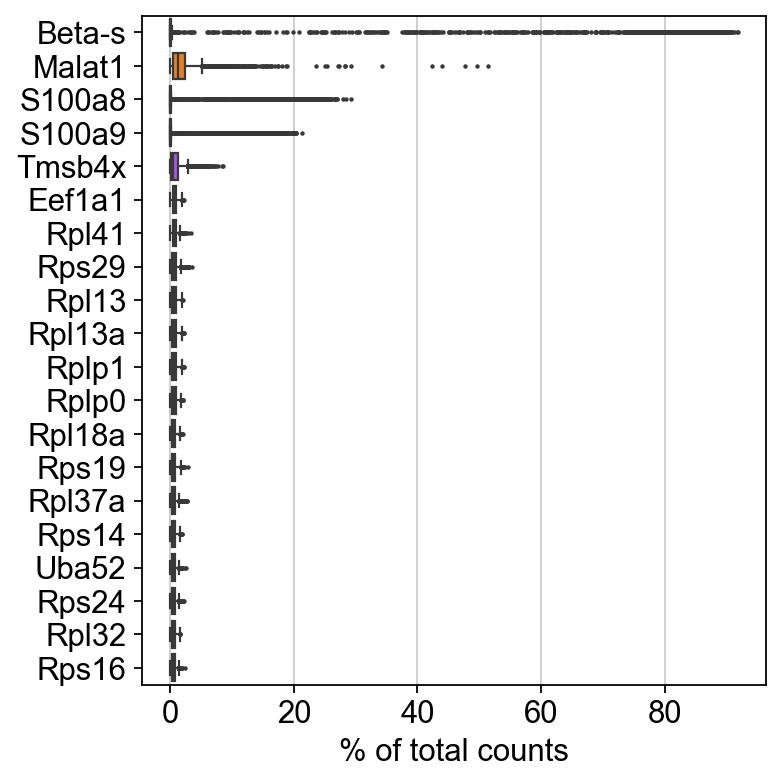

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Quality metrics

`sc.pp.calculate_qc_metrics` computes quality control metrics for each cell.
- Number of counts per cell
- Number of genes per cell
- Percentage of counts that come from mitochondrial genes.


In [8]:
adata.var['mt'] = adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

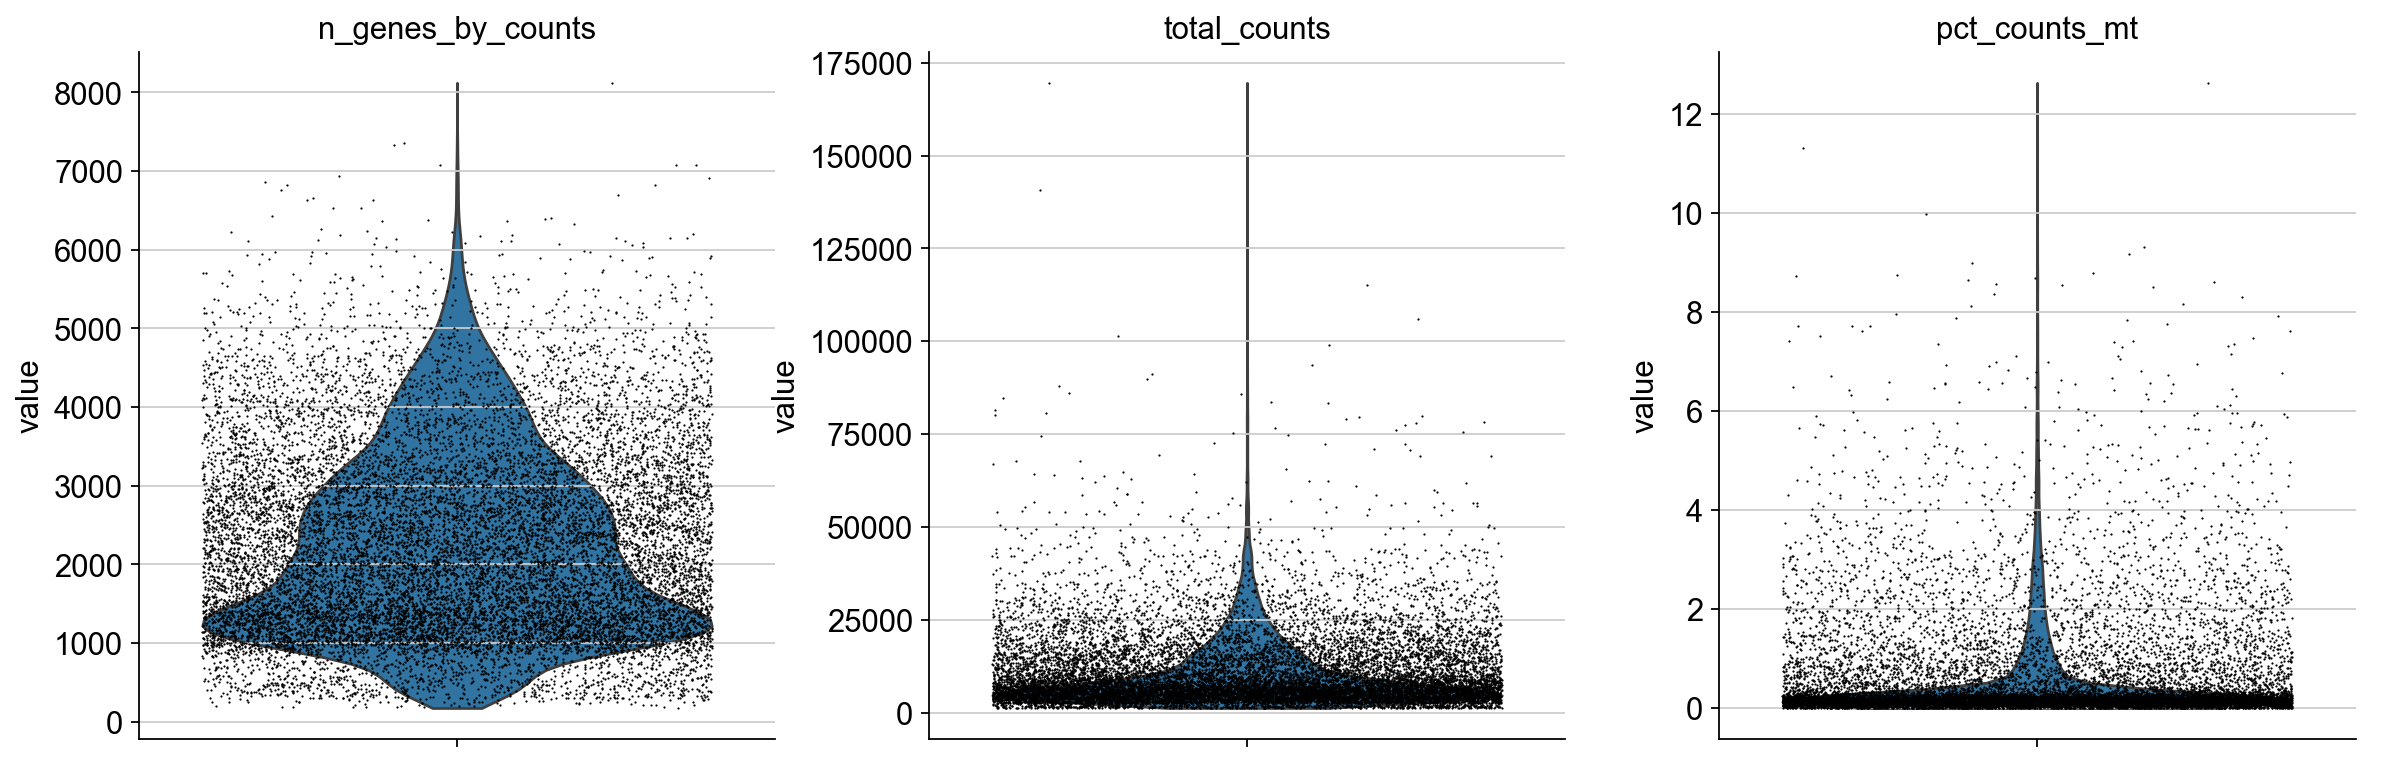

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Different sampes might require different thresholds


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotti

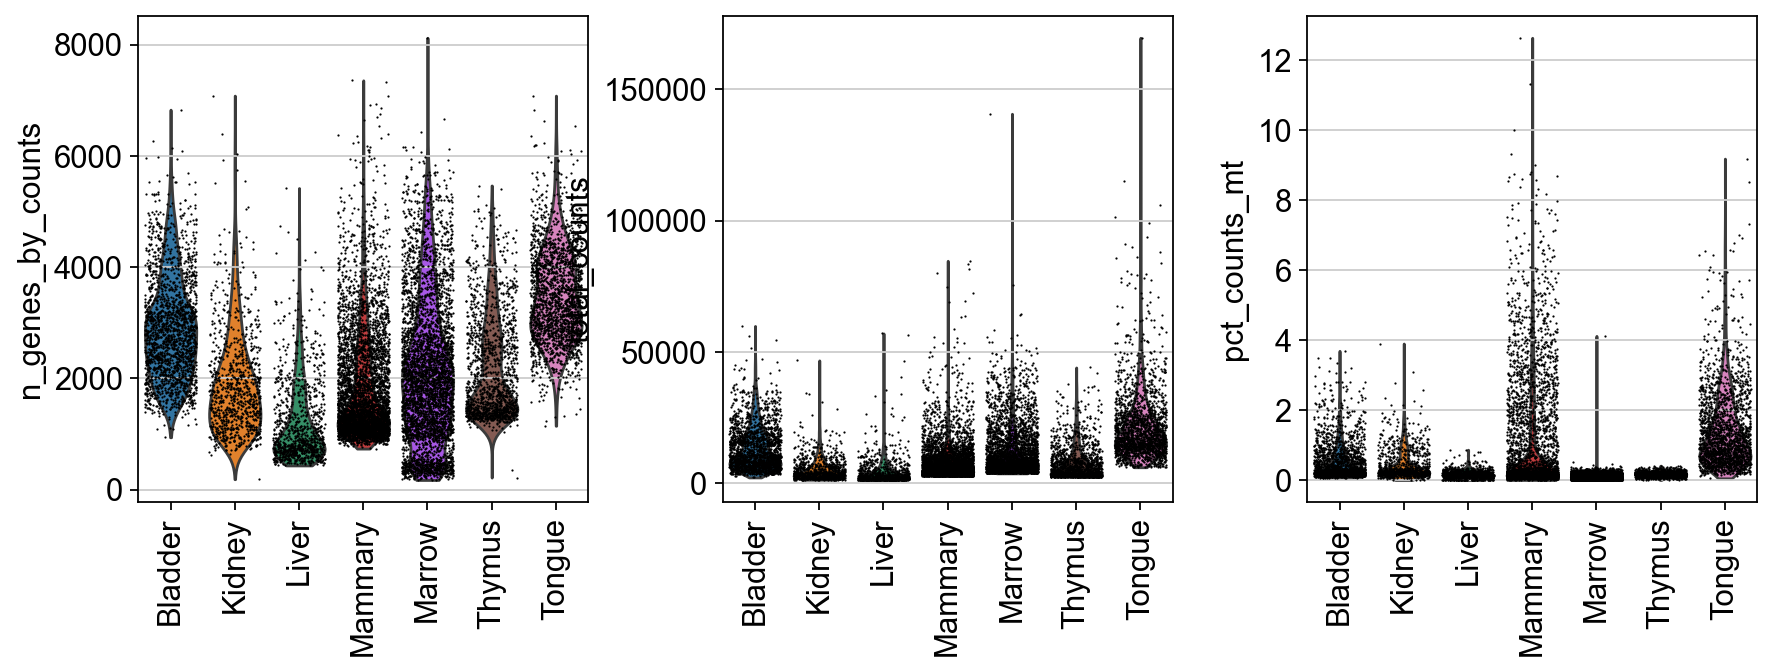

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, groupby='tissue', rotation = 90)

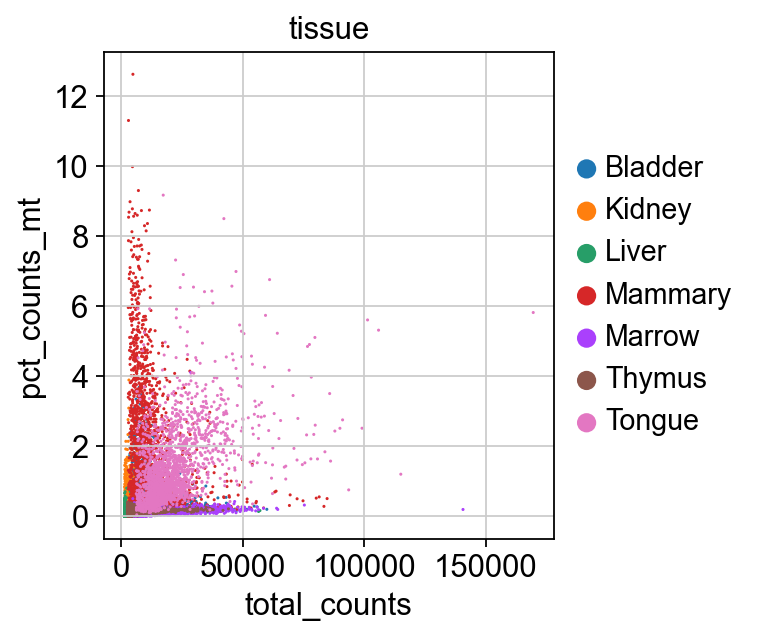

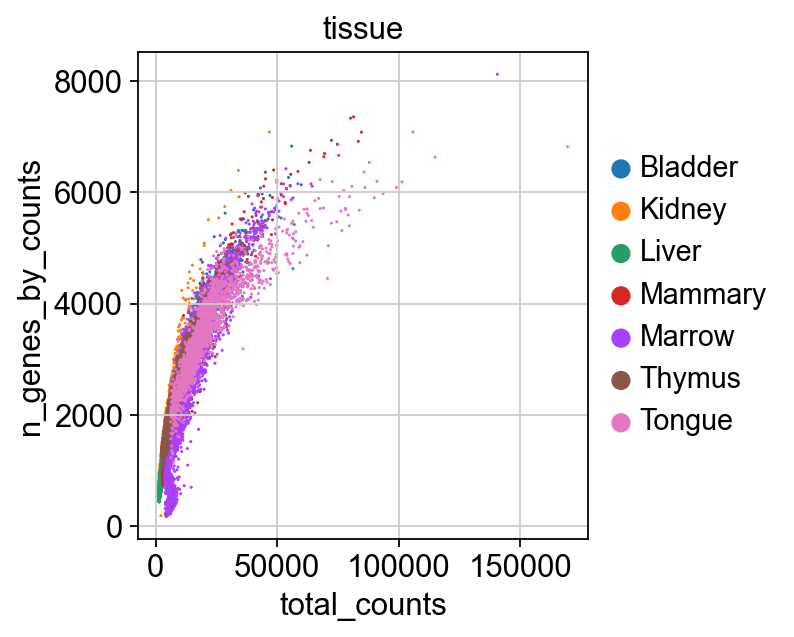

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='tissue')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='tissue')

## Filtering

Filter cells based on quality metrics


In [14]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=5)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

filtered out 524 genes that are detected in less than 5 cells


## Normalization

Normalise the data to the same total count per cell

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Logarithmize the 
>Why? To make the data more normally distributed

In [16]:
sc.pp.log1p(adata)

## Highly variable genes


In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

You can get back an AnnData of the object in .raw by calling .raw.to_adata().

In [18]:
adata.raw = adata

If you don’t proceed below with correcting the data with sc.pp.regress_out and scaling it via sc.pp.scale, you can also get away without using .raw at all.

The result of the previous highly-variable-genes detection is stored as an annotation in .var.highly_variable and auto-detected by PCA and hence, sc.pp.neighbors and subsequent manifold/graph tools. In that case, the step actually do the filtering below is unnecessary, too.

Actually do the filtering


In [19]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 9226 × 2619
    obs: 'channel', 'tissue', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'tissue_colors', 'log1p', 'hvg'

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.


In [20]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [21]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.


In [22]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:22)


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


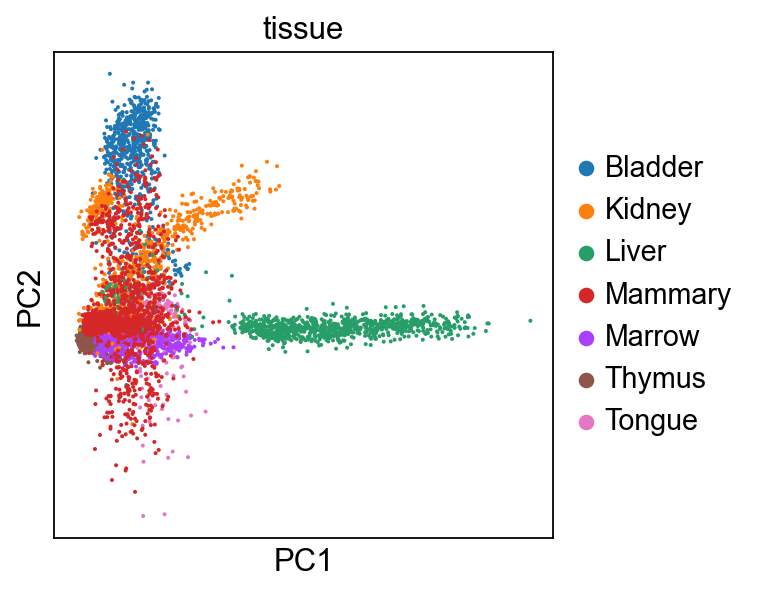

In [23]:
sc.pl.pca(adata, color='tissue')

Varinace explained by each component

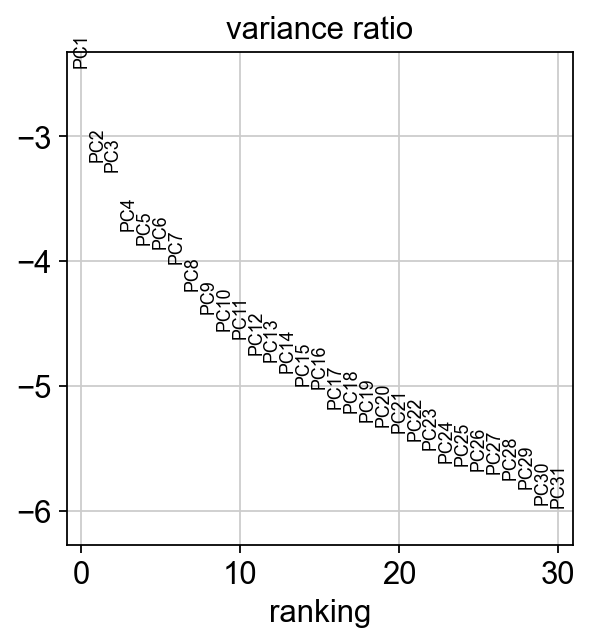

In [24]:
sc.pl.pca_variance_ratio(adata, log=True)

## Neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.


In [34]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:


In [42]:
sc.tl.leiden(adata, resolution=0.02)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
sc.tl.umap(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.

/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


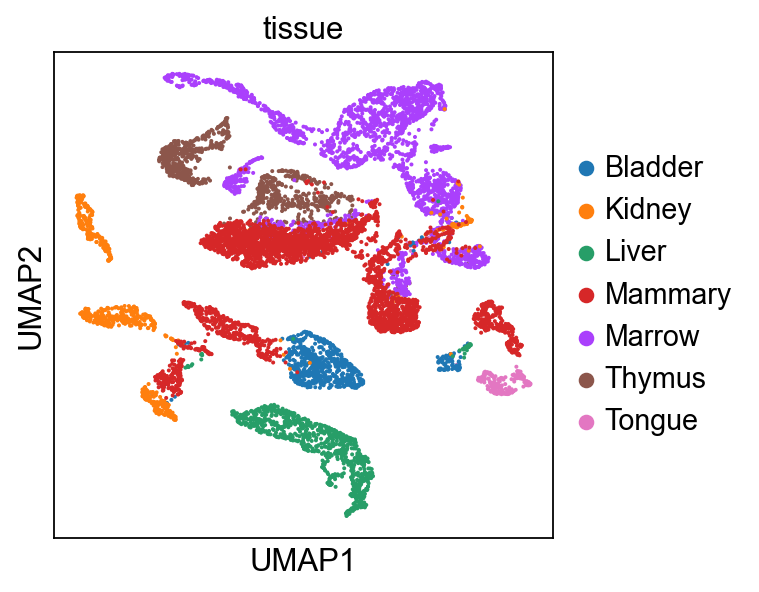

/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


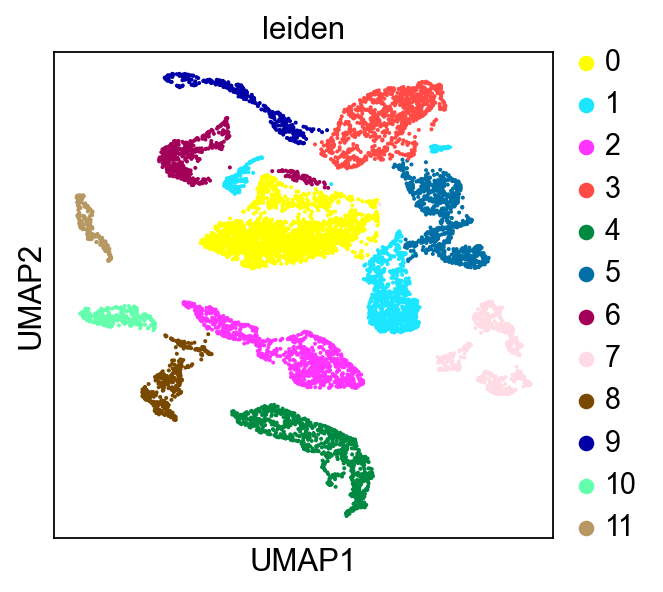

In [40]:
sc.pl.umap(adata, color='tissue', use_raw=False)
sc.pl.umap(adata, color='leiden', use_raw=False)

## Clustering the neighborhood graph
As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag et al. (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [ ]:
sc.tl.leiden(adata)

In [ ]:
sc.pl.umap(adata, color=['leiden', 'tissue'])

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.


In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

```
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
```


In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

adata = sc.read(results_file)
Show the 10 top ranked genes per cluster 0, 1, …, 7 in a dataframe.

pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
0	1	2	3	4	5	6	7
0	RPS12	LYZ	CD74	CCL5	NKG7	LST1	HLA-DPA1	PF4
1	LDHB	S100A9	CD79A	NKG7	GZMB	FCER1G	HLA-DPB1	SDPR
2	RPS25	S100A8	HLA-DRA	B2M	GNLY	AIF1	HLA-DRA	GNG11
3	RPS27	TYROBP	CD79B	CST7	CTSW	COTL1	HLA-DRB1	PPBP
4	RPS6	FTL	HLA-DPB1	GZMA	PRF1	FCGR3A	CD74	NRGN
Get a table with the scores and groups.

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)
0_n	0_p	1_n	1_p	2_n	2_p	3_n	3_p	4_n	4_p	5_n	5_p	6_n	6_p	7_n	7_p
0	RPS12	3.642456e-222	LYZ	1.007060e-252	CD74	3.043536e-182	CCL5	3.896273e-119	NKG7	4.689070e-95	LST1	5.650219e-85	HLA-DPA1	5.422417e-21	PF4	4.722886e-10
1	LDHB	3.242464e-216	S100A9	3.664292e-248	CD79A	6.860832e-170	NKG7	1.170992e-97	GZMB	2.381363e-89	FCER1G	1.697236e-81	HLA-DPB1	7.591860e-21	SDPR	4.733899e-10
2	RPS25	1.394016e-196	S100A8	9.457377e-239	HLA-DRA	8.398068e-166	B2M	3.032705e-81	GNLY	9.322195e-87	AIF1	1.377723e-79	HLA-DRA	1.306768e-19	GNG11	4.733899e-10
3	RPS27	9.718451e-188	TYROBP	2.209430e-224	CD79B	1.171444e-153	CST7	1.129293e-78	CTSW	1.035081e-85	COTL1	9.684016e-78	HLA-DRB1	1.865104e-19	PPBP	4.744938e-10
4	RPS6	1.771786e-185	FTL	3.910903e-219	HLA-DPB1	6.167786e-148	GZMA	4.263559e-73	PRF1	3.364126e-85	FCGR3A	2.516161e-76	CD74	5.853161e-19	NRGN	4.800511e-10
Compare to a single cluster:

sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)
ranking genes
    finished (0:00:01)
_images/pbmc3k_90_1.png
If we want a more detailed view for a certain group, use sc.pl.rank_genes_groups_violin.

sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)
_images/pbmc3k_92_0.png
Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)
_images/pbmc3k_95_0.png
If you want to compare a certain gene across groups, use the following.

sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')
_images/pbmc3k_97_0.png
Actually mark the cell types.

new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')
WARNING: saving figure to file figures/umap.pdf
_images/pbmc3k_100_1.png
Now that we annotated the cell types, let us visualize the marker genes.

sc.pl.dotplot(adata, marker_genes, groupby='leiden');
_images/pbmc3k_102_0.png
There is also a very compact violin plot.

sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);
_images/pbmc3k_104_0.png
During the course of this analysis, the AnnData accumlated the following annotations.


In [ ]:
adata

## What is the goal of this workshop?

## What is single-cell data?

What is single-cell RNA-seq and how does it compare to bulk RNA-seq?
What are some of the typical applications of scRNA-seq?
How are samples typically prepared for scRNA-seq?
What are the differences between some of the most popular protocols and what are their advantages and disadvantages?
What experimental design choices should be considered in scRNA-seq?
What are some of the challenges of scRNA-seq data compared to bulk data?




## Inspirations

- [Analysis of single cell RNA-seq data](https://www.singlecellcourse.org/)
    - Course from University of Cambridge Bioinformatics training unit
- [Single cell study database](www.nxn.se/single-cell-studies/)
- [Scanpy tutorials](https://scanpy-tutorials.readthedocs.io/en/latest/)